In [20]:
from importlib import reload
import platform, os, sys, datetime, re, itertools
from os.path import join
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tracker.tank import Tank
import tracker.utils as utils

tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8, 43:33.8 }
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 9,6

# Load trials

In [4]:
# trial_files = sorted(glob('../tracking/full_20-07-19/*/trial.pik')) # [:1]
trial_files = ['../tracking/full_20-09-25/Pa_Fri_14dpf_GroupA_n2b_20200612_1400/trial.pik']
print(len(trial_files))
# display(trial_files)

1


In [5]:
trials = {}
for trial_file in trial_files:
    
    # Parse the trial's name.
    trial_dir  = os.path.dirname(trial_file)
    trial_name = os.path.basename(trial_dir)
    pop,_,age,group,n_ind = trial_name.split('_')[:5]
    age        = int(age[:-3])
#     n_ind      = int(re.findall('\d+',n_ind)[0]) # The trial dictionary already contains n_ind.
    trial      = utils.load_pik(trial_file)
    locals().update(trial)
    tank.r_cm  = tank_diameter_vs_age[age]/2
 
    # Load the tracking data, originally a numpy.array, into a pandas.DataFrame.
    fish_list = range(n_ind)
    df = pd.DataFrame(data.reshape((data.shape[0],-1)))
    df.columns = pd.MultiIndex.from_product([ fish_list, ['x_px','y_px','ang','area'] ])
    df.index = pd.Index(frame_list.astype(float)/fps, name='time')
    
    # Create figure directory inside the tracking directory.
    fig_dir = os.path.join(trial_dir,'figures')
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    
    trials[trial_file] = { k:globals()[k] for k in ['trial_dir', 'trial_name', 'fig_dir', 
                                                    'pop', 'age', 'group','n_ind',
                                                    'df', 'fish_list', 'tank'] }

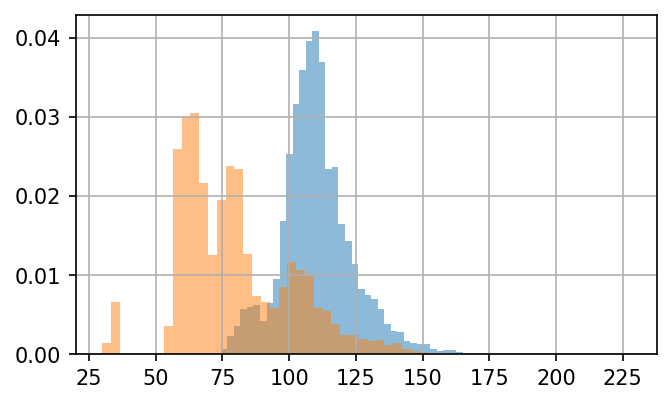

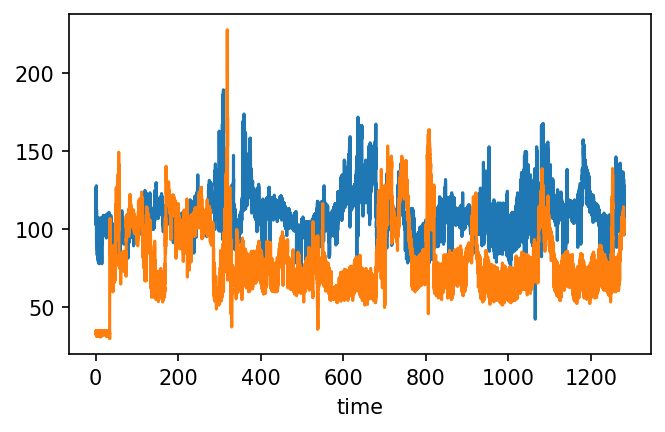

In [26]:
plt.figure(figsize=(5,3))
opt = dict(bins=60,alpha=0.5,density=True)
df[0,'area'].hist(**opt)
df[1,'area'].hist(**opt)
plt.show()

plt.figure(figsize=(5,3))
df[0,'area'].plot()
df[1,'area'].plot()
plt.show()

# Analyze


### Compute spatial and kinematic quantities

In [7]:
def derivative(series):
#     # First order forward derivative.
#     x,y = series.index,series.values
#     return pd.Series((y[1:]-y[:-1])/(x[1:]-x[:-1]),x[1:])
    # Second order centered derivative.
#     x,y = series.index,series.values
#     return pd.Series((y[2:]-y[:-2])/(x[2:]-x[:-2]),x[1:-1])
    return pd.Series(np.gradient(series,series.index),index=series.index)


for trial_file,trial in trials.items():
    locals().update(trial)
    
    # Convert pixels to cm.
    tank.r_cm = tank_diameter_vs_age[age]/2
    a = tank.r_cm/tank.r_px
    for i in range(n_ind):
        df[i,'x'] =  a*(df[i,'x_px']-tank.x_px)
        df[i,'y'] = -a*(df[i,'y_px']-tank.y_px)
    
    # Compute spatial and kinematic quantities.
    for f in fish_list:
        df[f,'d_wall'] = tank.r_cm - np.hypot(df[f,'x'],df[f,'y'])
        df[f,'v_x']    = derivative(df[f,'x'])
        df[f,'v_y']    = derivative(df[f,'y'])
        df[f,'v']      = np.hypot(df[f,'v_x'],df[f,'v_y'])
        # Make sure the difference between the current angle and the last
        # non-NaN angle is never larger than 2*pi, then take the derivative.
        I              = ~df[f,'ang'].isna()
        df[f,'ang'][I] = np.unwrap(df[f,'ang'][I])
        df[f,'v_ang']  = derivative(df[f,'ang'])
    
    # Reorder columns.
    # df = df.sort_index(axis=1) # Sort alphabetically, which also sorts by fish.
    columns = [ (f,q) for f in fish_list for q in ['x_px', 'y_px', 'area', 'ang', 'v_ang', 
                                                   'x', 'y', 'v_x', 'v_y', 'v', 'd_wall'] ]
    df = df.reindex(columns=columns)
    

### Perform cuts

In [8]:
for trial_file,trial in trials.items():
    locals().update(trial)
    
    cut_ranges = { 'd_wall': [0,tank.r_cm], 
                   'v':      [0,np.inf], 
                   'v_ang':  [-np.inf,np.inf] }
    
    cut_label  = ', '.join([ f'{v[0]}<={k.split(" ")[0]}<={v[1]}' for k,v in cut_ranges.items() ])
    columns    = pd.MultiIndex.from_product([ fish_list, ['NaN']+list(cut_ranges.keys())+['final'] ])
    cuts       = pd.DataFrame(index=df.index, columns=columns, dtype=bool)
    
    # Compute cuts.
    for f in fish_list:
        cuts[f,'NaN_xy'] = ~(df[f,'x'].isna() | df[f,'y'].isna())
        cuts[f,'NaN_any'] = ~df[f].isna().any(axis=1)
        for c,(vmin,vmax) in cut_ranges.items():
            cuts[f,c]  = (df[f,c]>=vmin) & (df[f,c]<=vmax)
        cuts[f,'final'] = cuts[f].all(axis=1)
        
    # Compute the fraction of points that made it through each cut.
    # Note: the denominator of the fraction depends on the cut; see below.
    cut_names = ['NaN_xy','NaN_any']+list(cut_ranges.keys())+['final']
    n_total   = len(df)*len(fish_list)
    n_valid   = { c:np.sum(cuts.loc[:,(slice(None),c)].values) for c in cut_names }
    valid_fraction = { 'NaN_xy': n_valid['NaN_xy']/n_total, 
                       'NaN_any': n_valid['NaN_any']/n_total, 
                       'd_wall': n_valid['d_wall']/n_valid['NaN_xy'], 
                       'v': n_valid['v']/n_valid['NaN_any'], 
                       'v_ang': n_valid['v']/n_valid['NaN_any'], 
                       'final': n_valid['final']/n_total }
    
    # Create filtered dataframe, i.e., perform the cut.
    df2 = df.copy()
    for f in fish_list:
        df2.loc[~cuts[f,'final'],f] = np.nan
    
    trial.update({ k:globals()[k] for k in ['cut_ranges', 'cut_label', 'cuts', 'valid_fraction', 'df2'] })

# Plot

*TODO*? Use an "acclimation cut" (dismiss the first xx minutes).

### Trajectories

In [9]:
for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    plt.figure(figsize=(6,)*2)
    circle = plt.Circle( (tank.x_px,tank.y_px), tank.r_px,
                         facecolor='None', edgecolor='k', lw=0.5 )
    plt.gca().add_patch(circle)
    for fish in range(data.shape[1]):
        x,y,theta,area = data[:,fish].T
        plt.scatter(x,y,s=0.1,linewidths=0,label=str(fish))
#         plt.plot(x,y,lw=0.5,label=str(fish))
    plt.axis('equal')
    plt.gca().yaxis.set_inverted(True)
    plt.legend()
    
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'trajectories.png'))
    plt.close()


In [ ]:
# plt.close('all')

### Angle dynamics

In [ ]:
for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    plt.figure(figsize=(12,6))
    for f in fish_list:
        a  = df[f,'ang']
        plt.plot(a.index,a,label=f) #,marker='.')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (rad)')
    plt.legend()
    
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'angle-vs-time.png'))
    plt.close()


### Valid fraction

In [ ]:
for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    bp = plt.bar(*zip(*valid_fraction.items()))
    for bar in bp:
        h,x,w = bar.get_height(),bar.get_x(),bar.get_width()
        plt.annotate(f'{h:.2f}', xy=(x+w/2,1.01), ha='center', va='bottom')
    plt.ylim(0,1.1)
    plt.ylabel('Valid fraction')
    
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'valid_fraction.png'))
    plt.close()


### Distance to the wall distribution

In [ ]:
for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    quantity = 'd_wall'
    unit = 'cm'
    bins = np.linspace(0,tank.r_cm,20)
    values = df2.loc[:,(slice(None),quantity)].values.flatten()
    plt.hist(values,bins=bins)
    plt.xlabel(f'{quantity} ({unit})')
    plt.ylabel('frequency')
    
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'dwall__histogram.png'))
    plt.close()


### Velocity distribution

In [ ]:
for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    quantity = 'v'
    unit = 'cm/s'
    bins = 30
    values = df2.loc[:,(slice(None),quantity)].values.flatten()
    plt.hist(values,bins=bins)
    plt.xlabel(f'{quantity} ({unit})')
    plt.ylabel('frequency')
    plt.yscale('log')

    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'v__histogram.png'))
    plt.close()


### Angular velocity distribution

In [ ]:
for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    quantity = 'v_ang'
    unit = 'rad/s'
    bins = 50

    values = df2.loc[:,(slice(None),quantity)].values.flatten()
    plt.hist(values,bins=bins)
    plt.xlabel(f'{quantity} ({unit})')
    plt.ylabel('frequency')
    plt.yscale('log')

    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'ang_v__histogram.png'))
    plt.close()


In [ ]:
# ''' Analyze instances of unusually high velocity. '''

# # At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# # corresponds to about pi/3 in one frame.
# print('v_ang for pi/3 in (1/30) second:',np.pi/3*fps)

# print('Instances of unusually high v_ang:')
# for f in fish_list:
#     ang_diff  = df[f,'ang'].diff()
#     I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
#     for i in I[:5]:
#         display(df[f,'ang'].iloc[i-1:i+2])

### Joint pair distance-pair angle distribution

In [ ]:
bins_d  = np.linspace(0,2*tank.r_cm,15) # pair distance bins for 2d histogram
bins_a  = np.linspace(0,np.pi,15)       # pair angle bins for 2d histogram
bins_d2 = np.linspace(0,2*tank.r_cm,30) # pair distance bins for polar OP vs distance

for trial_file,trial in trials.items():
#     print(trial_file)
    locals().update(trial)
    
    if n_ind<2:
        continue
    
    H = [] # 2d histogram
    P = np.zeros((len(bins_d2)+1,2)) # polar order parameter vs distance: running sum and count
    for f1,f2 in itertools.combinations(fish_list,2):
        dx,dy    = df[f1,'x']-df[f2,'x'],df[f1,'y']-df[f2,'y']
        d        = np.hypot(dx,dy)
        a        = df[f1,'ang']-df[f2,'ang']
        a        = np.absolute(a - 2*np.pi*np.rint(a/(2*np.pi)))
        
        h,_,_    = np.histogram2d(d,a,bins=(bins_d,bins_a),normed=True)
        H.append(h)
        
        I        = np.digitize(d,bins=bins_d2)
        P[I,0]  += np.cos(a)
        P[I,1]  += 1

    H = np.mean(H,axis=0)
    plt.pcolormesh(bins_d,bins_a*180/np.pi,H.T)
    plt.xlabel('pair distance (cm)')
    plt.ylabel('pair angle (deg)')
    plt.colorbar()
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'distance-angle__2d-histogram.png'))
    plt.close()
    
    P = P[:,0]/P[:,1]
    plt.plot(bins_d2,P[1:],marker='o',mfc='None',ms=4)
    plt.xlabel('pair distance (cm)')
    plt.ylabel('mean cosine of pair angle')
    plt.title(cut_label)
    plt.suptitle(trial_name)
    plt.savefig(os.path.join(fig_dir,f'polar-order-vs-distance.png'))
    plt.close()
    
    

# Clean up

In [ ]:
# for trial_file,trial in trials.items():
#     locals().update(trial)
    
#     # Delete figure directory and its contents.
# #     os.remove(fig_dir)
    